Corrosivity index and streamflow  to evaluate trends in potentially corrosive source waters in the Nation's streams and rivers (input)(1964-2016)

 Files containing CSMR and LR data input into WRTDS for all sites

Changes in water corrosivity from 84 river sites were investigated using long-term (1962 – 2016) data sets. Corrosive waters, often having elevated chloride (Cl) concentrations, can lead to metal leaching and promote corrosion in water distribution systems. Two different indices, the Chloride-Sulfate Mass Ratio (CSMR) and the Larson Ratio (LR), are commonly used to indicate the potential to promote corrosion in water distribution systems, with high values indicating an increase in the potential to promote corrosion. Though changes in treatment approaches at drinking water facilities are known to affect the corrosion indices, there is little information regarding how changes in the ionic composition of source waters may affect the corrosion indices. As part of the National Water-Quality Assessment (NAWQA) project of the National Water-Quality Program, long-term water-quality data from multiple sites across the Conterminous United States have been used to analyze seasonal- and flow-related variability and trends in the CSMR and LR indices.

 These input datasets contain corrosion index values and streamflow data to run WRTDS trend models to determine riverine trends for the CSMR and LR indices. CSMR was calculated as, CSMR = (Cl-) / (SO42-), where (Cl-) is the chloride concentration, expressed as mg Cl L-1 and (SO42-) is sulfate concentration expressed as mg SO42- L-1. LR was calculated as, LR = ((Cl- / 35.5) + (2 x (SO42- / 96.06))) / (2 x Alk / 100.8) where [Cl-], [SO42-], and [Alk] are the concentrations of chloride, sulfate, and alkalinity, respectively, expressed as mg Cl- L-1, mg SO42- L-1, and mg CaCO3 L-1, respectively. The data was used to output trend results from 1992 to 2012

Importing Libraries

In [183]:
#for mathematical computations
import pandas as pd
import numpy as np

#for data visualization 
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#for model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

## For modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

#for advanced modelling
!pip install catboost
import catboost
import lightgbm
import xgboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier  

## for pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#for evaluation 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

#for system settings 
import warnings
import os
import statsmodels.api as sm

#for model
import joblib

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:.5f}'.format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [126]:
#The two files which contain the corossion features and parameters dated
input_data = pd.read_csv('/content/drive/MyDrive/Corrosion-experiment-data-analysis-and-ml-algorithm/inputData.csv',parse_dates = ['date'])
flow_data = pd.read_csv('/content/drive/MyDrive/Corrosion-experiment-data-analysis-and-ml-algorithm/flowData.csv',parse_dates = ['dateTime'])

In [ ]:
input_data.head()

,Site_no,date,ParamLow,ParamHigh,Parameter,Uncen
0,01122610,1974-07-08,1.535396,1.535396,Larson,1
1,01122610,1974-07-08,0.801033,0.801033,CSMR,1
2,01122610,1974-08-05,2.020231,2.020231,Larson,1
3,01122610,1974-08-05,1.168173,1.168173,CSMR,1
4,01122610,1974-09-16,2.270041,2.270041,Larson,1


Most ParamLow and ParamHigh have close figures

In [ ]:
flow_data.head()

,site,dateTime,value
0,02089500,1964-10-01,1160.0
1,02089500,1964-10-02,2040.0
2,02089500,1964-10-03,2940.0
3,02089500,1964-10-04,4100.0
4,02089500,1964-10-05,6760.0


In [ ]:
input_data.columns

Index(['Site_no', 'date', 'ParamLow', 'ParamHigh', 'Parameter', 'Uncen'], dtype='object')

The input data contain the following the following features:

**Site_no**:- trend site number

**date**:- Day (YYYY-MM-DD)

**ParamLow**:- Lower limit of the CSMR or LR

**ParamHigh**:- Upper limit of the CSMR or LR

**Parameter**:- Describes the corrosion index parameter being analyzed

**Uncern**:- Uncensored data (1=true, 0=false)

**CSMR**:-Chloride-Sulfate Mass Ratio

**Larson**:-Larson Ratio 

In [ ]:
input_data.shape , flow_data.shape

((60274, 6), (1526359, 3))

flow_data is of no use at this point, Hence I am not considering it.


## Statistical Summarries

In [127]:
input_data.describe(include = 'all')

,Site_no,date,ParamLow,ParamHigh,Parameter,Uncen
count,60274,60274,60274.00000,60274.00000,60274,60274.00000
unique,92,10665,NaN,NaN,2,NaN
top,09522000,2000-06-07 00:00:00,NaN,NaN,CSMR,NaN
freq,2418,30,NaN,NaN,31809,NaN
first,NaN,1964-10-02 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2014-08-13 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.84179,inf,NaN,0.99902
std,NaN,NaN,9.87509,NaN,NaN,0.03127
min,NaN,NaN,0.00000,0.00021,NaN,0.00000
25%,NaN,NaN,0.39757,0.39817,NaN,1.00000


From the above statistical summary, we can deduce some of the following insights:

The data recovered provided ranges from **1964-10-02 00:00:00**	to **2014-08-13 00:00:00**

There is a big difference between the **ParamLow** and ParamHigh, the values recorded for each features are scaled and graded differently Hence, a standardization might be needed in the future


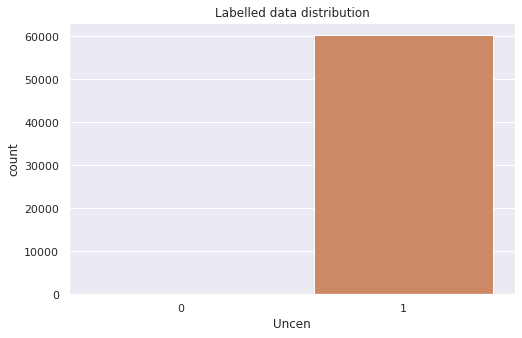

In [128]:
# labelled data distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(input_data["Uncen"])
plt.title('Labelled data distribution')
plt.show()

In [129]:
input_data[input_data['Uncen']==0].head()

,Site_no,date,ParamLow,ParamHigh,Parameter,Uncen
417,01122610,1999-08-09,1.23948,1.24356,Larson,0
13433,03155000_19415571,1999-08-03,0.52929,0.72846,Larson,0
19212,05474000,1998-06-18,0.13270,0.13351,Larson,0
21820,06340500_16249791,1969-10-14,0.79796,0.79830,Larson,0
21822,06340500_16249791,1969-11-12,0.88941,0.88975,Larson,0


The target distribution is not balanced, Hence some techniques must be employed to handle this imbalances

In [130]:
## It is clear that the minority class is un_corroded 0 so oversampling will be applyed to increase the observation of the un_corroded 

## implementation of resampling in the above dataset
from sklearn.utils import resample

## splitting the datasets into 2 dataframe based on the labels
corroded = input_data[input_data['Uncen']==1]
un_corroded = input_data[input_data['Uncen']==0]

## creating a dataframe of un_corroded by random oversampling
random_sampling = resample(un_corroded,random_state=0,replace=True,n_samples=len(corroded)) 

## combining the randomly sampled dataset with corroded dataset to form a new dataset
input_data=pd.concat([corroded,random_sampling])

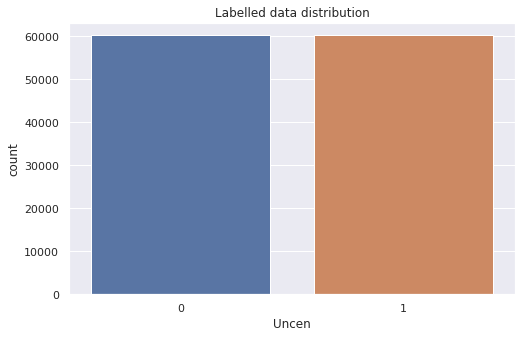

In [131]:
# Now lets make sure we have a uniform class distribution
# labelled data distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(input_data["Uncen"])
plt.title('Labelled data distribution')
plt.show()

In [132]:
# Check or missing values 
input_data.isnull().sum().any()

False

So no missing data for entries, well thats kind of stange thou for an experimental analysis

In [133]:
# Check for duplicate
input_data.duplicated().sum()

60156

Recordings are based on independent sites at different times and weather conditions. Also the differential gradient on factors affecting each might not be that far, Hence the similarity in data emtries

In [134]:
#getting rid of the infinite entries
with pd.option_context('mode.use_inf_as_na', True):
  input_data.dropna(inplace=True)

In [135]:
#Lets take a look at a the distribution of each features
data1 = input_data

In [136]:
data1.head()

,Site_no,date,ParamLow,ParamHigh,Parameter,Uncen
0,01122610,1974-07-08,1.53540,1.53540,Larson,1
1,01122610,1974-07-08,0.80103,0.80103,CSMR,1
2,01122610,1974-08-05,2.02023,2.02023,Larson,1
3,01122610,1974-08-05,1.16817,1.16817,CSMR,1
4,01122610,1974-09-16,2.27004,2.27004,Larson,1


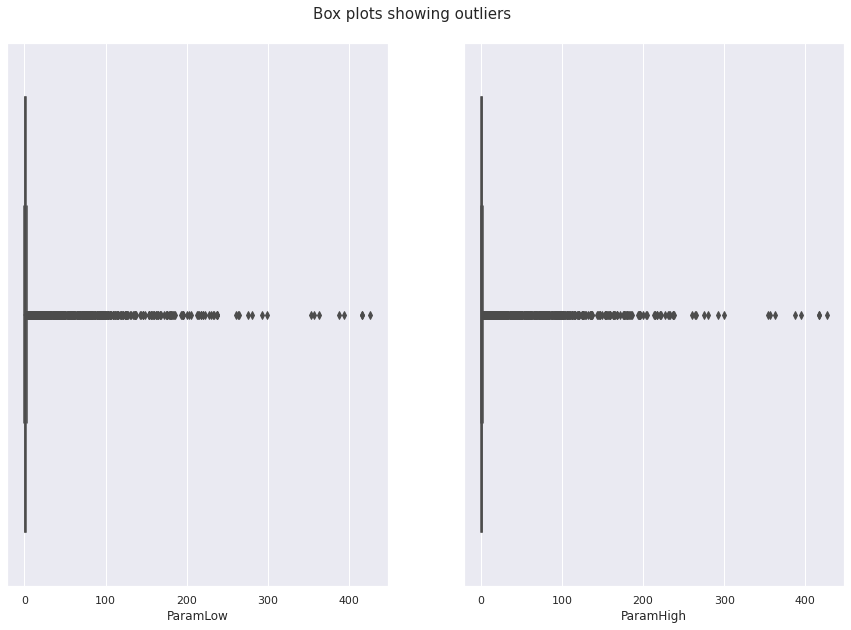

In [137]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), data1, ['ParamLow','ParamHigh',]):
  sns.boxplot(data1[name], ax = ax)

In [138]:
#finding the number of outliers for the price_per_unit
data_out_high = data1[data1['ParamHigh']>data1['ParamHigh'].quantile(0.99)]
data_out_low = data1[data1['ParamLow']>data1['ParamLow'].quantile(0.99)]
data_out_high.sum()['ParamHigh'], data_out_low.sum()['ParamLow']

(46298.64531924362, 46298.64531924362)

In [16]:
#outline numerical columns
param_cols = ['ParamHigh','ParamLow']

#function that analyse and give report of number and visulaisation of outliers
def num_of_outliers(data):
  param_cols = data.select_dtypes(include=['float64']).columns
  for col in (param_cols):
    num_of_outliers = data[data[col]>data[col].quantile(0.99)].shape[0]
    fig, ax = plt.subplots(1,1, figsize=(15, 6))
    sns.histplot(x = data[col])
    fig.text(0.1, 0.95, f'There are {num_of_outliers} outlier rows in {col} column', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel(' ', fontsize=20)
    plt.ylabel('')
    plt.yticks(fontsize=13)
    plt.box(False)

#finding the numbers of outliers
#num_of_outliers(data1)

In [139]:
data1.describe()

,ParamLow,ParamHigh,Uncen
count,120399.00000,120399.00000,120399.00000
mean,1.34597,1.37775,0.49987
std,6.98441,6.98263,0.50000
min,0.00000,0.00021,0.00000
25%,0.30064,0.30656,0.00000
50%,0.74533,0.79830,0.00000
75%,1.33505,1.38392,1.00000
max,426.77885,426.77885,1.00000


The fact the data set contains a big number outliers does not invalidate its significance 

Empirical observations and recordings are expected to varies due to many factors which must be observed

I think it will be a really bad idea getting rid of them 

In [140]:
# Extract day, month year and hour from the date column
#day
data1['day'] = data1.date.dt.day
#months
data1['month'] = data1.date.dt.month
#year
data1['year'] = data1.date.dt.year

#encode the engineered date features
LE = LabelEncoder()
data1['day'] = LE.fit_transform(data1['day'])
data1['month'] = LE.fit_transform(data1['month'])
data1['year'] = LE.fit_transform(data1['year'])

In [141]:
data1 = data1.drop('date',axis =1)

In [142]:
data1.head()

,Site_no,ParamLow,ParamHigh,Parameter,Uncen,day,month,year
0,01122610,1.53540,1.53540,Larson,1,7,6,10
1,01122610,0.80103,0.80103,CSMR,1,7,6,10
2,01122610,2.02023,2.02023,Larson,1,4,7,10
3,01122610,1.16817,1.16817,CSMR,1,4,7,10
4,01122610,2.27004,2.27004,Larson,1,15,8,10


In [143]:
#encoding the parameter too
data1['Parameter'] = LE.fit_transform(data1['Parameter'])

#creating more features
data1['Param1'] = data1['ParamHigh'] + data1['ParamLow']
data1['Param2'] = data1['ParamHigh'] - data1['ParamLow']


In [144]:
data1['m_Param1'] = data1.groupby('month').sum()['Param1']
data1['d_Param1'] = data1.groupby('day').sum()['Param1']

data1['m_Param2'] = data1.groupby('month').sum()['Param2']
data1['d_Param2'] = data1.groupby('day').sum()['Param2']

data1['mm_Param1'] = data1.groupby('month')['Param1'].transform('mean')
data1['dd_Param1'] = data1.groupby('day')['Param1'].transform('mean')

data1['mm_Param2'] = data1.groupby('month')['Param2'].transform('mean')
data1['dd_Param2'] = data1.groupby('day')['Param2'].transform('mean')

In [60]:
#data1= data1.drop('m_Param',axis=1)

In [145]:
data1.head()

,Site_no,ParamLow,ParamHigh,Parameter,Uncen,day,month,year,Param1,Param2,m_Param1,d_Param1,m_Param2,d_Param2,mm_Param1,dd_Param1,mm_Param2,dd_Param2
0,01122610,1.53540,1.53540,1,1,7,6,10,3.07079,0.00000,14481.82706,8053.47428,79.85652,226.14829,4.03102,2.71734,0.01712,0.03509
1,01122610,0.80103,0.80103,0,1,7,6,10,1.60207,0.00000,23068.26959,11151.93409,91.56931,58.29737,4.03102,2.71734,0.01712,0.03509
2,01122610,2.02023,2.02023,1,1,4,7,10,4.04046,0.00000,20598.46267,9918.33111,8.59350,218.12570,3.11342,2.62502,0.03558,0.04161
3,01122610,1.16817,1.16817,0,1,4,7,10,2.33635,0.00000,27201.62825,7721.58547,124.62427,4.41730,3.11342,2.62502,0.03558,0.04161
4,01122610,2.27004,2.27004,1,1,15,8,10,4.54008,0.00000,53203.38078,16445.76196,1356.42209,260.70492,2.91235,2.79580,0.01116,0.06392


In [146]:
data1.isnull().sum()

Site_no           0
ParamLow          0
ParamHigh         0
Parameter         0
Uncen             0
day               0
month             0
year              0
Param1            0
Param2            0
m_Param1     120387
d_Param1     120368
m_Param2     120387
d_Param2     120368
mm_Param1         0
dd_Param1         0
mm_Param2         0
dd_Param2         0
dtype: int64

Date Features EDA

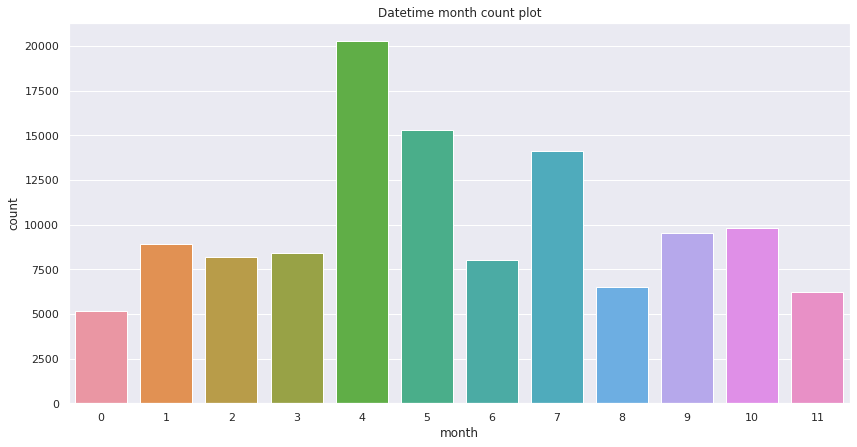

In [32]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'month', data = data1)
plt.title('Datetime month count plot')
plt.show()

All months were recoreded and considered in the experiment

May has the highest record of observation while January has the lowest

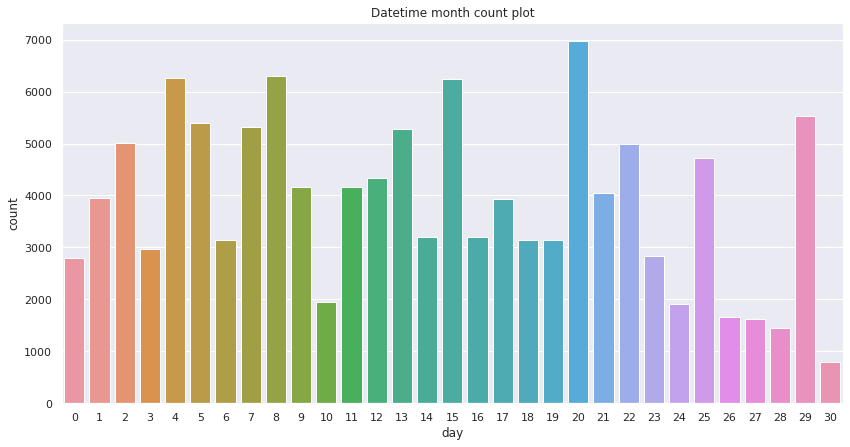

In [33]:
# Datetime day countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'day', data = data1)
plt.title('Datetime month count plot')
plt.show()

#### probably there is no need for this visualization as no insight could be obtained

In [147]:
data1.head()

,Site_no,ParamLow,ParamHigh,Parameter,Uncen,day,month,year,Param1,Param2,m_Param1,d_Param1,m_Param2,d_Param2,mm_Param1,dd_Param1,mm_Param2,dd_Param2
0,01122610,1.53540,1.53540,1,1,7,6,10,3.07079,0.00000,14481.82706,8053.47428,79.85652,226.14829,4.03102,2.71734,0.01712,0.03509
1,01122610,0.80103,0.80103,0,1,7,6,10,1.60207,0.00000,23068.26959,11151.93409,91.56931,58.29737,4.03102,2.71734,0.01712,0.03509
2,01122610,2.02023,2.02023,1,1,4,7,10,4.04046,0.00000,20598.46267,9918.33111,8.59350,218.12570,3.11342,2.62502,0.03558,0.04161
3,01122610,1.16817,1.16817,0,1,4,7,10,2.33635,0.00000,27201.62825,7721.58547,124.62427,4.41730,3.11342,2.62502,0.03558,0.04161
4,01122610,2.27004,2.27004,1,1,15,8,10,4.54008,0.00000,53203.38078,16445.76196,1356.42209,260.70492,2.91235,2.79580,0.01116,0.06392


In [148]:
data1.isnull().sum()

Site_no           0
ParamLow          0
ParamHigh         0
Parameter         0
Uncen             0
day               0
month             0
year              0
Param1            0
Param2            0
m_Param1     120387
d_Param1     120368
m_Param2     120387
d_Param2     120368
mm_Param1         0
dd_Param1         0
mm_Param2         0
dd_Param2         0
dtype: int64

In [149]:
fill_cols = ['m_Param1','d_Param1','m_Param2','d_Param2']
for col in fill_cols:
  data1[col] = data1[col].fillna(data1[col].mean())

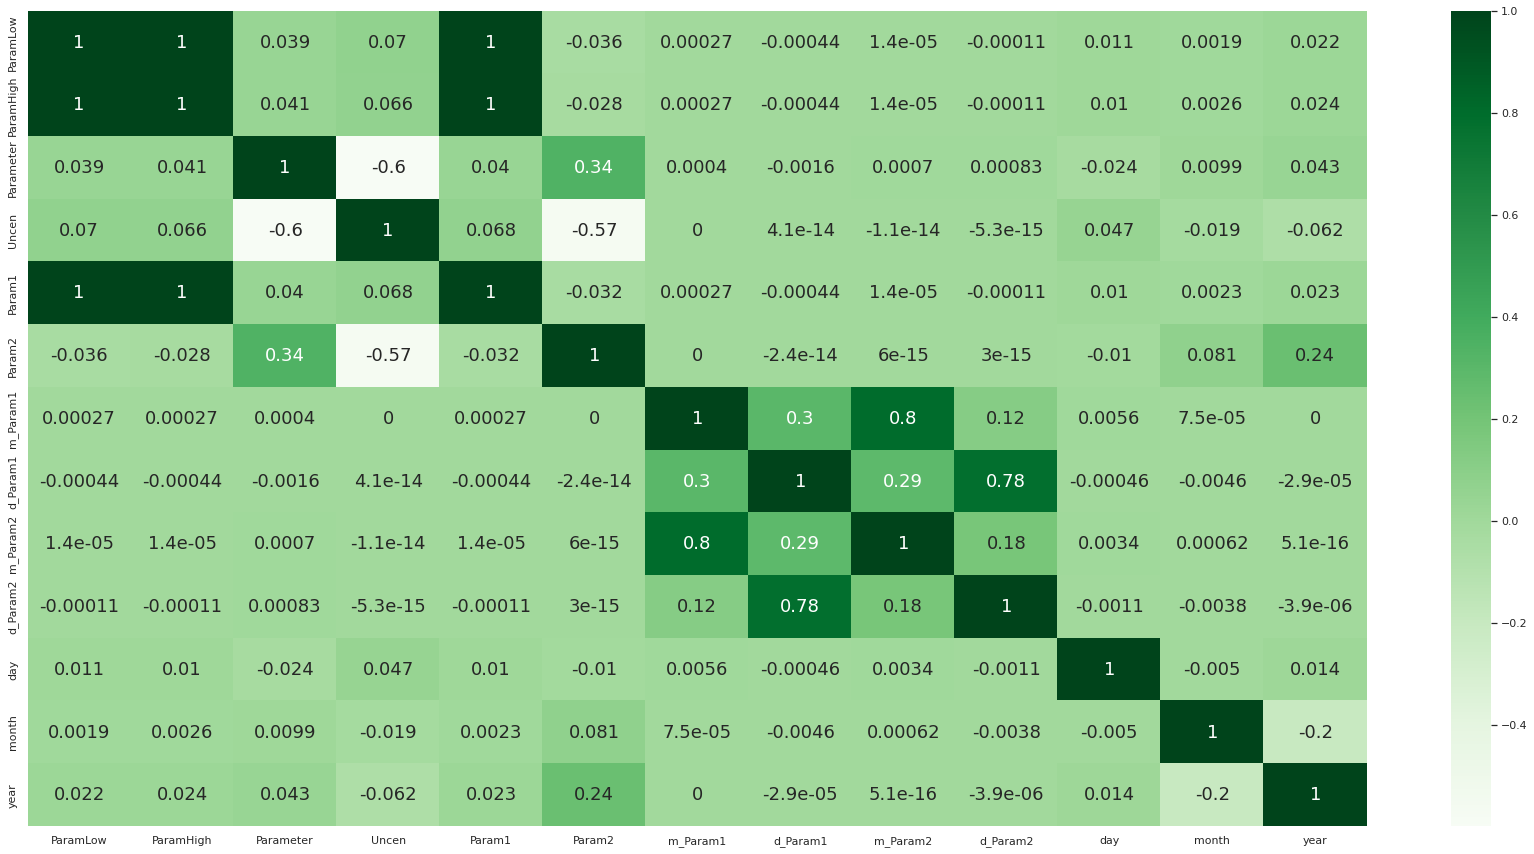

In [150]:
fig, ax = plt.subplots(1,1, figsize=(30,15))
sns.heatmap(data1[['ParamLow','ParamHigh', 'Parameter', 'Uncen','Param1','Param2','m_Param1','d_Param1','m_Param2','d_Param2','day', 'month', 'year']].corr(), cmap='Greens',annot=True)

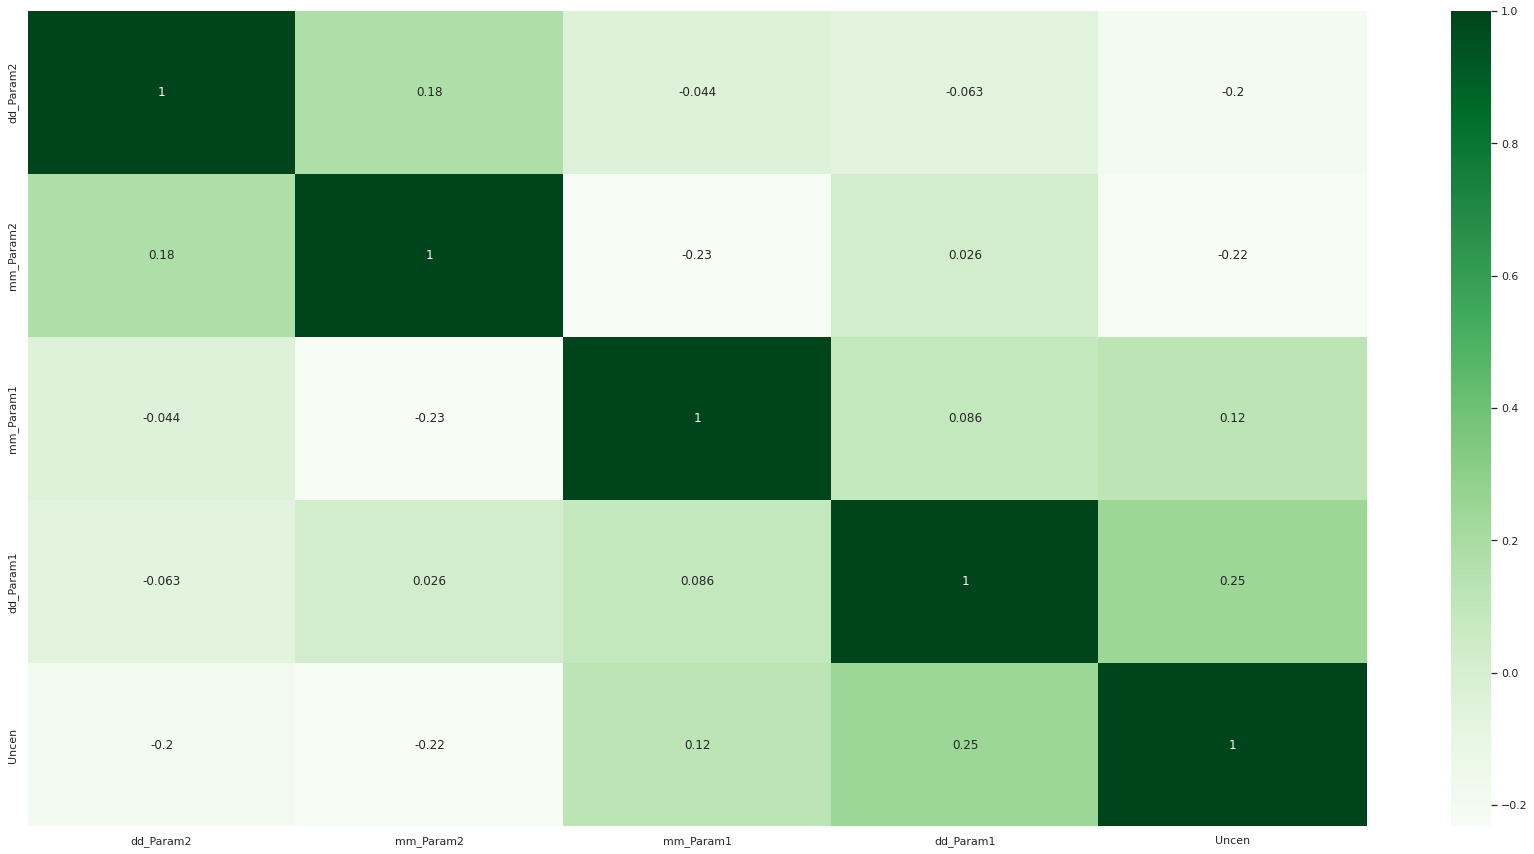

In [104]:
fig, ax = plt.subplots(1,1, figsize=(30,15))
sns.heatmap(data1[['dd_Param2','mm_Param2','mm_Param1','dd_Param1','Uncen']].corr(), cmap='Greens',annot=True)

In [151]:
data1.corr()['Uncen'].sort_values()

Parameter   -0.59897
Param2      -0.56841
mm_Param2   -0.22155
dd_Param2   -0.19591
year        -0.06215
month       -0.01886
m_Param2    -0.00000
d_Param2    -0.00000
m_Param1     0.00000
d_Param1     0.00000
day          0.04654
ParamHigh    0.06571
Param1       0.06797
ParamLow     0.07023
mm_Param1    0.12048
dd_Param1    0.24633
Uncen        1.00000
Name: Uncen, dtype: float64

In [105]:
data1[['m_Param2','d_Param2','m_Param1','d_Param1']].head(5)

,m_Param2,d_Param2,m_Param1,d_Param1
0,79.85652,226.14829,14481.82706,8053.47428
1,91.56931,58.29737,23068.26959,11151.93409
2,8.59350,218.12570,20598.46267,9918.33111
3,124.62427,4.41730,27201.62825,7721.58547
4,1356.42209,260.70492,53203.38078,16445.76196


In [106]:
data1[['dd_Param2','mm_Param2','mm_Param1','dd_Param1']].head(5)

,dd_Param2,mm_Param2,mm_Param1,dd_Param1
0,0.03509,0.01712,4.03102,2.71734
1,0.03509,0.01712,4.03102,2.71734
2,0.04161,0.03558,3.11342,2.62502
3,0.04161,0.03558,3.11342,2.62502
4,0.06392,0.01116,2.91235,2.79580


Splitting of datasets

In [107]:
data1.shape

(120399, 18)

In [ ]:
## The infinty values has to be taken care of to allow ease of pipeline implementation
#data2 = data1.replace([np.inf,-np.inf],np.nan)
#data2.dropna(inplace=True)

In [64]:
#data2.shape

In [167]:
## Only 60000 were entered correctly
## Hence it is splitted into train and test 
train0 = data1.loc[:40000,:]
test0 = data1.loc[40000:,]

In [168]:
print( train0.shape,test0.shape)

(39965, 18) (80435, 18)


In [169]:
train = test0
test = train0

In [170]:
print( train.shape,test.shape)

(80435, 18) (39965, 18)


Modelling

In [171]:
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
to_drop 

['ParamHigh', 'Param1']

In [115]:
train[to_drop].corr()

,ParamHigh,Param1
ParamHigh,1.00000,1.00000
Param1,1.00000,1.00000


In [172]:
# Initialize an empty array to hold feature importances
X = train.drop(['Site_no'],axis=1)
y = train['Uncen']
feature_importances_lgb = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = LGBMClassifier(n_estimators=10000,
                      random_state=32,
                      )
# Fit the model twice to avoid overfitting

for i in range(2):
    
    # Split into training and validation set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = i,shuffle=True)
    
    # Train using early stopping
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'roc_auc_score', verbose = 200)
    
    # Record the feature importances
    feature_importances_lgb += model.feature_importances_

# Make sure to average feature importances! 
feature_importances_lgb = feature_importances_lgb / 2
feature_importances_lgb = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances_lgb}).sort_values('importance', ascending = False)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 3.0173e-08
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 3.0173e-08
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 3.32995e-08
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 3.32995e-08


In [173]:
# Find the features with zero importance
zero_features = list(feature_importances_lgb[feature_importances_lgb['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances_lgb.head(100)

There are 4 features with 0.0 importance


,feature,importance
0,ParamLow,668.50000
3,Uncen,162.00000
1,ParamHigh,130.50000
4,day,98.00000
6,year,81.50000
7,Param1,74.50000
8,Param2,30.50000
14,dd_Param1,15.50000
16,dd_Param2,15.00000
13,mm_Param1,11.00000


In [119]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [174]:
# Initialize an empty array to hold feature importances
X = train.drop(['Site_no'],axis=1)
y = train['Uncen']
feature_importances_lgb = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = RandomForestClassifier(
                      random_state=32,
                      )
# Fit the model twice to avoid overfitting

for i in range(2):
    
    # Split into training and validation set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = i,shuffle=True)
    
    # Train using early stopping
    model.fit(X_train, y_train)
    
    # Record the feature importances
    feature_importances_lgb += model.feature_importances_

# Make sure to average feature importances! 
feature_importances_lgb = feature_importances_lgb / 2
feature_importances_lgb = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances_lgb}).sort_values('importance', ascending = False)


In [175]:
## Prediction on test set
predictions = model.predict(X_test)

## Metrics 
print(classification_report(y_test,predictions))

print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14971
           1       1.00      1.00      1.00      5138

    accuracy                           1.00     20109
   macro avg       1.00      1.00      1.00     20109
weighted avg       1.00      1.00      1.00     20109

1.0


Feature: 0, Score: 0.49716
Feature: 1, Score: -0.42932
Feature: 2, Score: -8.48519
Feature: 3, Score: 15.45107
Feature: 4, Score: -0.06360
Feature: 5, Score: -0.52488
Feature: 6, Score: -0.06327
Feature: 7, Score: 0.06784
Feature: 8, Score: -0.92648
Feature: 9, Score: -0.00019
Feature: 10, Score: -0.00008
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 1.09216
Feature: 14, Score: 3.24744
Feature: 15, Score: -0.15420
Feature: 16, Score: -0.12399


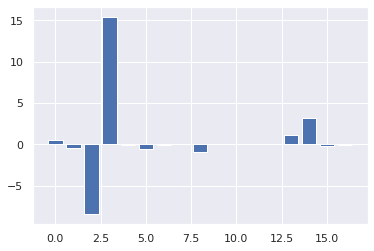

In [176]:
# define the model
LoRmodel = LogisticRegression(random_state=32)

# fit the model
LoRmodel.fit(X_train, y_train)

# get importance
importance = LoRmodel.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.99957
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00043
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000


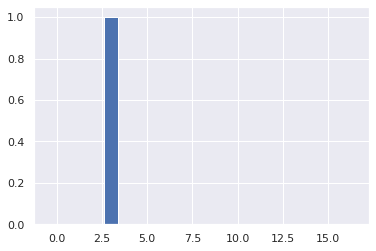

In [178]:
# define the model
XGBRmodel = XGBClassifier()

# fit the model
XGBRmodel.fit(X_train, y_train)

# get importance
importance = XGBRmodel.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [179]:
## Prediction on test set
predictions = model.predict(X_test)

## Metrics 
print(classification_report(y_test,predictions))

print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14971
           1       1.00      1.00      1.00      5138

    accuracy                           1.00     20109
   macro avg       1.00      1.00      1.00     20109
weighted avg       1.00      1.00      1.00     20109

1.0


In [ ]:
# define the model
KNCmodel = KNeighborsClassifier()

# fit the model
KNCmodel.fit(X_train, y_train)

# perform permutation importance
results = permutation_importance(KNCmodel, X_train, y_train, scoring='accuracy')

# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
## This Pipeline will contain the preprocessing steps which includes:
## Scaling of numerical features
## Encoding of categorical features

In [ ]:
## Define Features and Labels
features = ['ParamLow', 'ParamHigh', 'Parameter', 'Datetime_day' ,'Datetime_month',	'Datetime_year']
labels = ['Uncen']


## Declare variables
X = data1[features]
y = data1[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)


In [ ]:
#With Pipeline
## define preprocessing for numeric features(scale them)
numeric_features = ['ParamHigh','ParamLow','Datetime_day','Datetime_month','Datetime_year']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


## define preprocessing for categorical features(encode them)
categorical_features = ['Parameter',]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


## amalgamate preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


## create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])

## fit the pipeline to train a linear regression model on the training set
PIPEmodel = pipeline.fit(X_train,y_train)
print (PIPEmodel)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ParamHigh', 'ParamLow',
                                                   'Datetime_day',
                                                   'Datetime_month',
                                                   'Datetime_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Parameter'])])),
                ('classifier', DecisionTreeClassifier())])


In [ ]:
## Prediction on test set
PIPEpredictions = PIPEmodel.predict(X_test)

## Metrics 
print(classification_report(y_test,PIPEpredictions))

print(accuracy_score(y_test,PIPEpredictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18118
           1       1.00      1.00      1.00     18002

    accuracy                           1.00     36120
   macro avg       1.00      1.00      1.00     36120
weighted avg       1.00      1.00      1.00     36120

0.9996677740863787


###### The predict_proba function cannot be used in this case as the y_test is a binary value and not a multi countinous target

In [ ]:
print(roc_auc_score(y_test,PIPEpredictions))

0.999666703699589


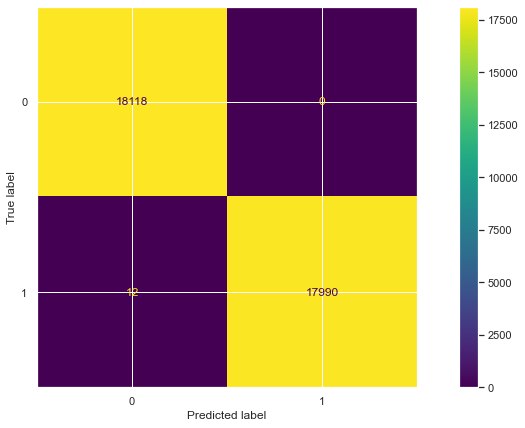

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, PIPEpredictions, labels=PIPEmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=PIPEmodel.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

The model predicts quite well on the test set, However Perfomance can still be improved 

Considering the metrics roc_auc_score, 
RandomForestClassifier proved to be the best model

LogisticRegression        0.8283801799800022

RandomForestClassifier    0.9999722253082991

DecisionTreeClassifier    0.9996667036995890

In [ ]:
## Saving the best model as a pickle file

filename = './MODELS.pkl'
joblib.dump(PIPEmodel, filename)




['./MODELS.pkl']